# Hippocampus

## Pattern separation

Define DG block

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        hidden_layer_size = input_size + output_size // 2
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        # self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.fc1 = nn.Linear(input_size, output_size)
        
        # Weight initialization (Xavier)
        nn.init.xavier_uniform_(self.fc1.weight)
        # nn.init.xavier_uniform_(self.fc2.weight)
        self.k = 20  # Number of top activations to keep
        
    def forward(self, x):
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            x = self.fc1(x)
            x = torch.tanh(x)  # Using tanh activation
            # x = self.fc2(x)
            # x = torch.relu(x)
            # Top-k sparsity: keep only top-k values, set others to zero
            mask = torch.zeros_like(x)
            _, topk_indices = torch.topk(x, self.k)
            mask.scatter_(0, topk_indices, 1)
            x = x * mask
        return x


We need some data to test these blocks

In [70]:
import math

# dg_model - Sparse encoding
N = 25  # Input size
M = 25 * 100   # Output size

# ec_to_ca3_model - Correcting encoding
H = N + M  # Input size
L = M   # Output size ?? M ??

# ca3_memory_model
T = M + L # Input size
K = T # Output size = Input size

# ca1_model
input_size = N + K # the original input pattern + memory
hidden_size = math.floor(input_size * 0.7)  # Size of hidden layer
output_size = N  # Same as input size for reconstruction

# super simple ARC-like example
input_1 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]]]], dtype=torch.float)

output_1 = torch.tensor([[[[0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0],
                           [1, 1, 1, 1, 1],
                           [0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0]]]], dtype=torch.float)

input_2 = torch.tensor([[[[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1]]]], dtype=torch.float)

output_2 = torch.tensor([[[[0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [1, 1, 1, 1, 1]]]], dtype=torch.float)

We are going to work with 1D arrays. 

DG block creates a sparse representation of the input

In [71]:
dg_model = DGModel(N, M)

def forward_dg_model(dg_model, x):
    return dg_model(x.flatten())


In [72]:
x = input_1.flatten()
a = output_1.flatten()

y = forward_dg_model(dg_model, x)
print(y)
print(y.shape)

tensor([0., 0., 0.,  ..., -0., 0., 0.])
torch.Size([2500])


Before the sparse representation hits the memory
we need to add one independent network between the same input and the memory in parallel.
This will be used later as part of retrieval.
Its gould would be to help balance between sparse representation and real input and select important regions 
(that would help with ignoring noise (or with detecting invariants))

We add an Encoding model

In [73]:
class EncodingModel(nn.Module):
    """
    Goal: pattern retrieval
    Methods: compare sparse representation with the original
    """
    
    def __init__(self, input_size, output_size):
        super(EncodingModel, self).__init__()
        hidden_layer_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [74]:
ec_model = EncodingModel(H, L)
ec_optimizer = optim.Adam(ec_model.parameters(), lr=0.001)
ec_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ec_to_ca3_model(ec_model, x, y):
    yy = torch.cat([y, x])
    return ec_model(yy)

def train_ec_to_ca3_model(ec_model, x, y):
    # Zero the parameter gradients
    ec_optimizer.zero_grad()

    # Compare reconstruction with the original input
    
    z = forward_ec_to_ca3_model(ec_model, x, y)
    loss = ec_criterion(z, y)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ec_optimizer.step()

    print("Loss:", loss.item())
    print("EC -> CA3 output:", z)
    
    return z


In [75]:
z = train_ec_to_ca3_model(ec_model, x, y)
print(z)
print(z.shape)

Loss: 0.0006211262079887092
EC -> CA3 output: tensor([ 0.0082, -0.0169, -0.0025,  ...,  0.0238, -0.0246,  0.0037],
       grad_fn=<AddBackward0>)
tensor([ 0.0082, -0.0169, -0.0025,  ...,  0.0238, -0.0246,  0.0037],
       grad_fn=<AddBackward0>)
torch.Size([2500])


## Memory

This is where patterns are stored. Associative memory is implemented by classic Hopfield networks (there are also Modern Hopfield Networks that pose as a generalization of Transformers, that is not what is used here :( )

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1) * 10.0  # Make it a column vector
        self.weights += torch.mm(p, p.T) # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=100):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            state = input_state.clone()
            prev_state = state.clone()

            for _ in range(max_steps):
                # Update all neurons at once for simplicity
                net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
                state = torch.tanh(net_input)  # Continuous activation (differentiable)
            
                # For each neuron, update its state
                # for i in range(self.num_neurons):
                #     net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
                #     state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

                # Early stopping if state does not change
                if torch.equal(state, prev_state):
                    break
                prev_state = state.clone()

            return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights.detach().numpy(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

In [77]:

hopfield_model = HopfieldNetworkTorch(T)

def forward_ca3_memory_model(hopfield_model, y, z):
    ca3_input = torch.cat([y, z]) # y -> M, z -> L
    input_state = torch.tensor(ca3_input, dtype=torch.float32)
    u = hopfield_model(input_state)
    return u

def train_ca3_memory_model(hopfield_model, y, z):
    ca3_input = torch.cat([y, z])
    hopfield_model.store_pattern(ca3_input)
    u = forward_ca3_memory_model(hopfield_model, y, z)
    return u


In [78]:
u = train_ca3_memory_model(hopfield_model, y, z)

C:\Users\neupo\AppData\Local\Temp\ipykernel_12332\506196239.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_state = torch.tensor(ca3_input, dtype=torch.float32)


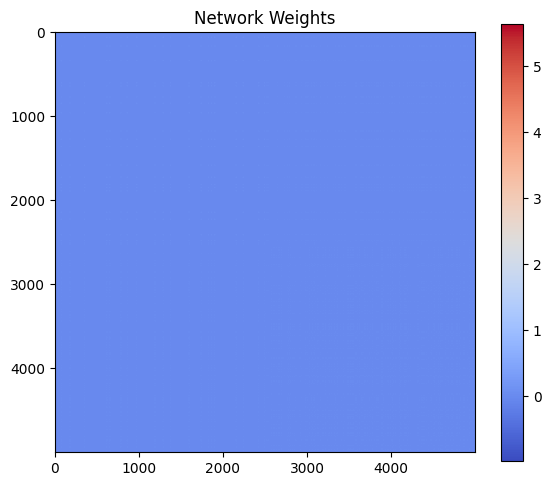

In [79]:
hopfield_model.plot_weights()

In [80]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, h, d_model, d_context, d_output):
        super(Attention, self).__init__()
        self.h = h
        self.d_k = d_model // h
        self.d_v = d_context
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_output)

    def forward(self, z):
        if len(z.shape) == 1:
            batch_size = 1
        else:
            batch_size = z.shape[0]
        
        zz = z.view(batch_size, self.d_k)
        q = zz[:, :]
        k = zz[:, :]
        v = zz[:, :]
        
        query = self.q_linear(q)
        key = self.k_linear(k)
        value = self.v_linear(v)
        
        key_t = key.transpose(-2, -1)
        scores = torch.matmul(query, key_t) / math.sqrt(self.d_k)
        for x in range(self.d_v):
            for y in range(self.d_v):
                if y < x:
                    scores[:, x, y] = torch.zeros((batch_size))
                    
        p_attn = F.softmax(scores, dim=-1)

        x = torch.matmul(p_attn, value)

        x = self.out_linear(x)
        x = torch.sum(x, 1)
        return x

### Visualization

This is what is really stored in memory. Trying to grasp what kind of transformation happens in these three networks.

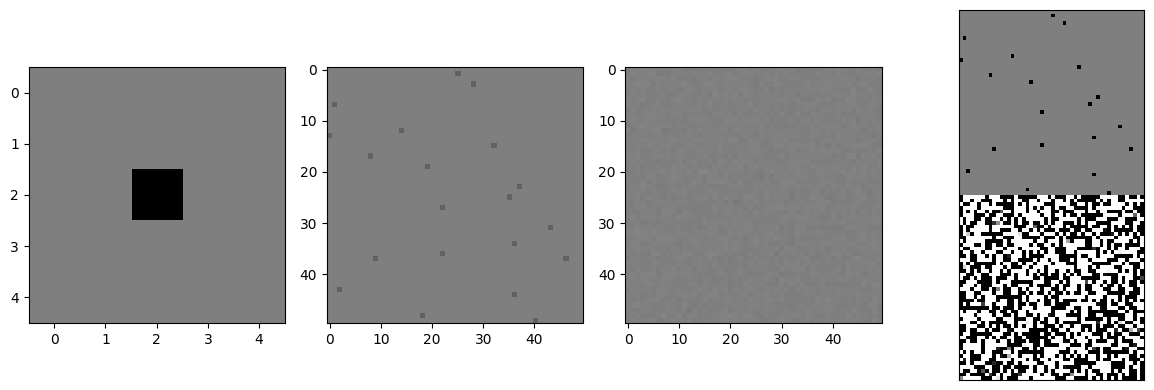

In [81]:
cmap = plt.cm.gray
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(x.view(5,5), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(50, 50), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(50, 50), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(100, 50), cmap=plt.cm.gray_r, norm=norm)


# Plot the figure
#plt.figure(figsize=(6, 4))
#plt.imshow(x, cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

## Mapping and reconstruction

This is the last block that is mainly used for retrieval.  

In [82]:
class MappingModel(nn.Module):
    """
    Goal: pattern mapping
    Methods: compare what stored in memory with the original
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MappingModel, self).__init__()
        
        # Layers for mapping and reconstruction
        self.fc_map = nn.Linear(input_size, hidden_size)  # Map Hopfield output to hidden representation
        self.fc_reconstruct = nn.Linear(hidden_size, output_size)  # Reconstruct to original size

    def forward(self, x):
        """
        Forward pass compares stored Hopfield output with the original input
        """
        # Map the Hopfield output to a hidden representation
        mapping = self.fc_map(x)
        hidden_repr = torch.relu(mapping)
        reconstructed_input = self.fc_reconstruct(hidden_repr)
        return reconstructed_input

In [83]:

# Instantiate the model
ca1_model = MappingModel(input_size, hidden_size, output_size)

# Define optimizer (e.g., Adam)
ca1_optimizer = optim.Adam(ca1_model.parameters(), lr=0.0001)

ca1_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ca1_model(ca1_model, u, x):
    ca1_input = torch.cat([u, x]) # u -> K, x -> N
    # Compare reconstruction with the original input
    v = ca1_model(ca1_input)
    return v
    
def train_ca1_model(ca1_model, u, x, a):
    # Zero the parameter gradients
    ca1_optimizer.zero_grad()

    v = forward_ca1_model(ca1_model, u, x)
    loss = ca1_criterion(v, a)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ca1_optimizer.step()

    print("Loss:", loss.item())
    print("Reconstructed Input:", v)
    
    return v

Loss: 0.2707344889640808
Reconstructed Input: tensor([-0.2383,  0.1909,  0.1025,  0.1660, -0.1097, -0.0726,  0.1836,  0.0971,
        -0.1561,  0.0087,  0.1287,  0.1508,  0.4054,  0.1189,  0.0207,  0.0772,
        -0.1099,  0.3489,  0.1440,  0.0867,  0.0114, -0.0404,  0.0728,  0.0097,
         0.2246], grad_fn=<AddBackward0>)


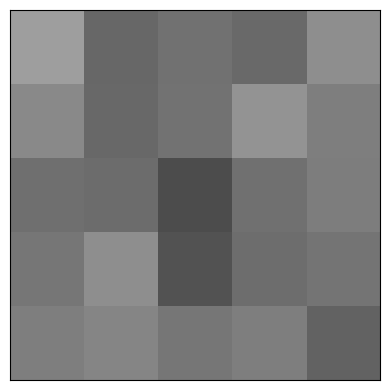

In [84]:
v = train_ca1_model(ca1_model, u, x, a)

# Plot the figure
plt.figure(figsize=(6, 4))
plt.imshow(v.view(5,5).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

Loss: 0.020682642236351967
Reconstructed Input: tensor([-0.1201, -0.0902,  1.2224,  0.0290,  0.1044,  0.0471, -0.0123,  1.2854,
        -0.0293, -0.0150,  1.0077,  1.2770,  1.0287,  1.1446,  1.2391,  0.0470,
         0.0736,  1.1066, -0.0707,  0.0660, -0.0506,  0.0314,  1.3896, -0.0258,
        -0.0917], grad_fn=<AddBackward0>)


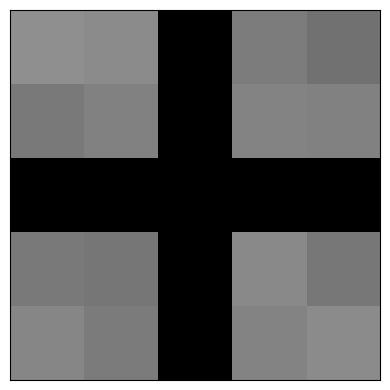

In [85]:
# Another step
v = train_ca1_model(ca1_model, u, x, a)

plt.figure(figsize=(6, 4))
plt.imshow(v.view(5,5).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [86]:

x = input_2.flatten()
a = output_2.flatten()

y = forward_dg_model(dg_model, x)
z = train_ec_to_ca3_model(ec_model, x, y)
u = train_ca3_memory_model(hopfield_model, y, z)
v = train_ca1_model(ca1_model, u, x, a)


Loss: 0.002899324521422386
EC -> CA3 output: tensor([-0.0564,  0.0533,  0.0453,  ..., -0.0521,  0.0450, -0.0471],
       grad_fn=<AddBackward0>)
Loss: 0.5027092695236206
Reconstructed Input: tensor([-0.0015, -0.0290, -0.5318,  0.3455, -0.1010, -0.3115, -0.0784, -0.3115,
         0.2311,  0.0586, -0.3552, -0.3319, -0.0847,  0.1983, -0.5948, -0.0863,
         0.1181, -0.2625,  0.1293,  0.1521, -0.1481,  0.2291, -0.4686,  0.0050,
        -0.0494], grad_fn=<AddBackward0>)


C:\Users\neupo\AppData\Local\Temp\ipykernel_12332\506196239.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_state = torch.tensor(ca3_input, dtype=torch.float32)


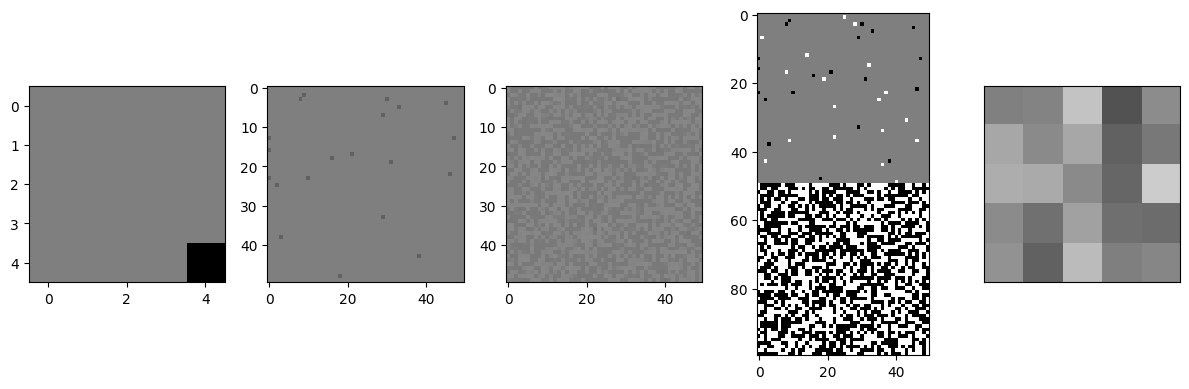

In [87]:
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
axs[0].imshow(x.view(5,5), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(50, 50), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(50, 50), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(100, 50), cmap=plt.cm.gray_r, norm=norm)
axs[4].imshow(v.view(5, 5).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

Loss: 0.04400596022605896
Reconstructed Input: tensor([-0.0353,  0.0288, -0.2453,  0.1649,  0.8296, -0.0965,  0.0076, -0.1226,
        -0.0992,  0.6567, -0.2159, -0.0971, -0.1764, -0.1578,  0.4786,  0.0364,
         0.0684, -0.1597,  0.0480,  0.7700,  0.8626,  0.8835,  0.5358,  0.7423,
         0.7886], grad_fn=<AddBackward0>)


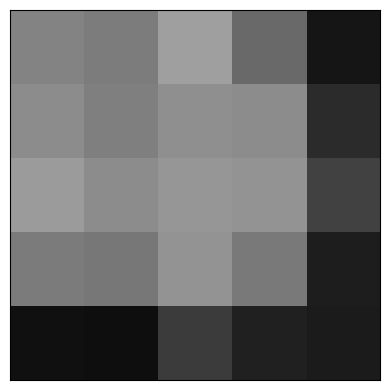

In [88]:
# Another step
v = train_ca1_model(ca1_model, u, x, a)

plt.figure(figsize=(6, 4))
plt.imshow(v.view(5,5).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

C:\Users\neupo\AppData\Local\Temp\ipykernel_12332\506196239.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_state = torch.tensor(ca3_input, dtype=torch.float32)


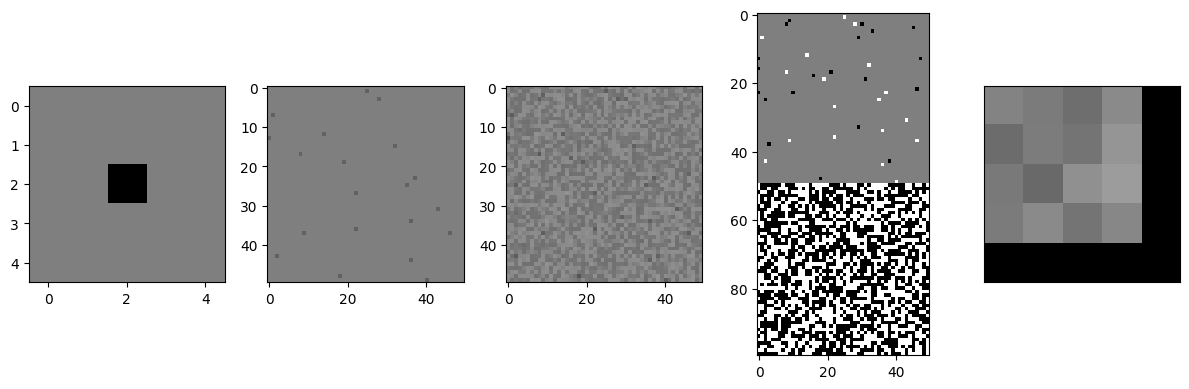

In [89]:

x = input_1.flatten()
a = output_1.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x, y)
    u = forward_ca3_memory_model(hopfield_model, y, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(5,5), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(50, 50), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(50, 50), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(100, 50), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(5, 5).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

C:\Users\neupo\AppData\Local\Temp\ipykernel_12332\506196239.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_state = torch.tensor(ca3_input, dtype=torch.float32)


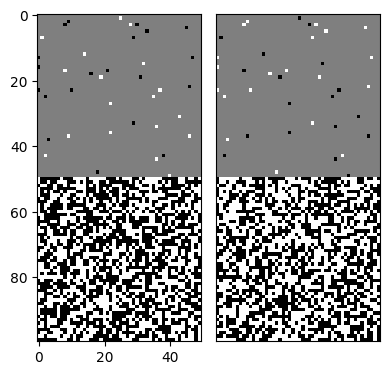

In [90]:

with torch.no_grad():
    x1 = input_1.flatten()
    a1 = output_1.flatten()

    y1 = forward_dg_model(dg_model, x1)
    z1 = forward_ec_to_ca3_model(ec_model, x1, y1)
    u1 = forward_ca3_memory_model(hopfield_model, y1, z1)

    x2 = input_2.flatten()
    a2 = output_2.flatten()

    y2 = forward_dg_model(dg_model, x2)
    z2 = forward_ec_to_ca3_model(ec_model, x2, y2)
    u2 = forward_ca3_memory_model(hopfield_model, y2, z2)


    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
    axs[0].imshow(u1.view(100, 50), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(u2.view(100, 50), cmap=plt.cm.gray_r, norm=norm)


plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()